In [1]:
#Librerías utilizadas
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [2]:
#Esta librería permite importar archivos desde google drive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Se añade el dataset desde google drive llamado "totalhouses" contiene el consumo energético de 11 casas cada media hora
totalhouses = pd.read_csv('gdrive/My Drive/Colab Notebooks/totalhouses.csv', parse_dates=['tstp'], index_col="tstp")

In [4]:
#Se muestra el contenido del dataset
totalhouses.head()

,house1,house2,house3,house4,house5,house6,house7,house8,house9,house10,house11,consumo_agregado
tstp,,,,,,,,,,,,
2011-11-23 13:30:00,0.110,0.075,0.055,0.938,0.201,0.049,0.01,0.250,0.176,0.151,0.458,2.473
2011-11-23 14:00:00,0.244,0.064,0.144,1.650,0.185,0.048,0.00,0.163,0.092,0.059,0.534,3.183
2011-11-23 14:30:00,0.241,0.318,0.106,0.752,0.248,0.048,0.00,0.177,0.093,0.088,0.353,2.424
2011-11-23 15:00:00,0.287,0.185,0.116,0.713,0.486,0.049,0.00,0.162,0.158,0.086,0.242,2.484
2011-11-23 15:30:00,0.296,0.121,0.139,0.261,0.281,0.048,0.00,0.162,0.142,0.116,0.324,1.890


In [5]:
#tipo de variable
totalhouses.dtypes

house1              float64
house2              float64
house3              float64
house4              float64
house5              float64
house6              float64
house7              float64
house8              float64
house9              float64
house10             float64
house11             float64
consumo_agregado    float64
dtype: object

In [0]:
#Se le asigna los valores del totalhouses a dataset1 para iniciar la normalización
dataset1 = totalhouses.values

In [0]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset1)

In [8]:
dataset[0:5]

array([[0.0499031 , 0.0135083 , 0.0130674 , 0.20513392, 0.06254417,
        0.12468193, 0.01594896, 0.06963562, 0.07115629, 0.13063062,
        0.21242996, 0.21432105],
       [0.11482558, 0.00926283, 0.04367263, 0.36406249, 0.05689046,
        0.1221374 , 0.        , 0.03441295, 0.03557814, 0.04774774,
        0.25114622, 0.30212714],
       [0.11337209, 0.10729448, 0.03060523, 0.16361607, 0.07915194,
        0.1221374 , 0.        , 0.04008097, 0.03600169, 0.07387387,
        0.15894041, 0.20826119],
       [0.13565891, 0.05596295, 0.03404402, 0.15491071, 0.16325088,
        0.12468193, 0.        , 0.0340081 , 0.0635324 , 0.07207207,
        0.1023943 , 0.21568143],
       [0.14001937, 0.03126206, 0.04195323, 0.05401786, 0.09081272,
        0.1221374 , 0.        , 0.0340081 , 0.05675561, 0.09909909,
        0.1441671 , 0.14222112]])

In [9]:
#Dividimos el dataset, seleccionamos 70% para entrenamiento y 30% para test
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

27765 11900


In [10]:
dataset[0:5]

array([[0.0499031 , 0.0135083 , 0.0130674 , 0.20513392, 0.06254417,
        0.12468193, 0.01594896, 0.06963562, 0.07115629, 0.13063062,
        0.21242996, 0.21432105],
       [0.11482558, 0.00926283, 0.04367263, 0.36406249, 0.05689046,
        0.1221374 , 0.        , 0.03441295, 0.03557814, 0.04774774,
        0.25114622, 0.30212714],
       [0.11337209, 0.10729448, 0.03060523, 0.16361607, 0.07915194,
        0.1221374 , 0.        , 0.04008097, 0.03600169, 0.07387387,
        0.15894041, 0.20826119],
       [0.13565891, 0.05596295, 0.03404402, 0.15491071, 0.16325088,
        0.12468193, 0.        , 0.0340081 , 0.0635324 , 0.07207207,
        0.1023943 , 0.21568143],
       [0.14001937, 0.03126206, 0.04195323, 0.05401786, 0.09081272,
        0.1221374 , 0.        , 0.0340081 , 0.05675561, 0.09909909,
        0.1441671 , 0.14222112]])

In [0]:
#Almacenaiento del look back para poder hacer el entrenamiento
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 11])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
#Estableciendo el valor del look backs
look_back = 300
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

27465
11600


In [13]:
trainX.shape

(27465, 300, 12)

In [0]:
#Reorganizando los datos para el modelo
trainX = np.reshape(trainX, (trainX.shape[0], 300, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 300, testX.shape[2]))

In [15]:
trainX.shape

(27465, 300, 12)

In [16]:
testX.shape

(11600, 300, 12)

In [17]:
trainX.shape[1]

300

In [18]:
trainX.shape[2]

12

W0707 00:03:07.301212 139889551550336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 00:03:07.359324 139889551550336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 00:03:07.368250 139889551550336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 00:03:07.645858 139889551550336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 00:03:07.902503 139889551550336 deprecation.py:323

Train on 27465 samples, validate on 11600 samples
Epoch 1/50
 - 110s - loss: 0.0062 - val_loss: 0.0051
Epoch 2/50
 - 160s - loss: 0.0049 - val_loss: 0.0050
Epoch 3/50
 - 160s - loss: 0.0047 - val_loss: 0.0048
Epoch 4/50
 - 159s - loss: 0.0046 - val_loss: 0.0047
Epoch 5/50
 - 159s - loss: 0.0045 - val_loss: 0.0046
Epoch 6/50
 - 160s - loss: 0.0045 - val_loss: 0.0047
Epoch 7/50
 - 160s - loss: 0.0044 - val_loss: 0.0047
Epoch 8/50
 - 160s - loss: 0.0043 - val_loss: 0.0047
Epoch 9/50
 - 161s - loss: 0.0043 - val_loss: 0.0046
Epoch 10/50
 - 159s - loss: 0.0043 - val_loss: 0.0046
Epoch 11/50
 - 159s - loss: 0.0042 - val_loss: 0.0049
Epoch 12/50
 - 159s - loss: 0.0042 - val_loss: 0.0047
Epoch 13/50
 - 159s - loss: 0.0042 - val_loss: 0.0045
Epoch 14/50
 - 159s - loss: 0.0041 - val_loss: 0.0046
Epoch 15/50
 - 160s - loss: 0.0041 - val_loss: 0.0045
Epoch 16/50
 - 159s - loss: 0.0041 - val_loss: 0.0045
Epoch 17/50
 - 159s - loss: 0.0040 - val_loss: 0.0047
Epoch 18/50
 - 158s - loss: 0.0040 - val_

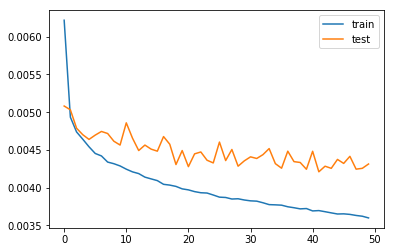

In [0]:
#Estructura de la red, ajustamos los parámetros del modelo LSTM
model = Sequential()
model.add(LSTM (60, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='RMSProp')
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
#Estructura de la red y número de parámetros
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                17520     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 17,581
Trainable params: 17,581
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Predicción del consumo de energía  de las 11 casas y el consumo agregado
yhat = model.predict(testX)
yhat[0:5]

array([[0.06303358],
       [0.11984849],
       [0.14874871],
       [0.15348285],
       [0.13365042]], dtype=float32)

In [0]:
#largo de yhat
len(yhat)

11600

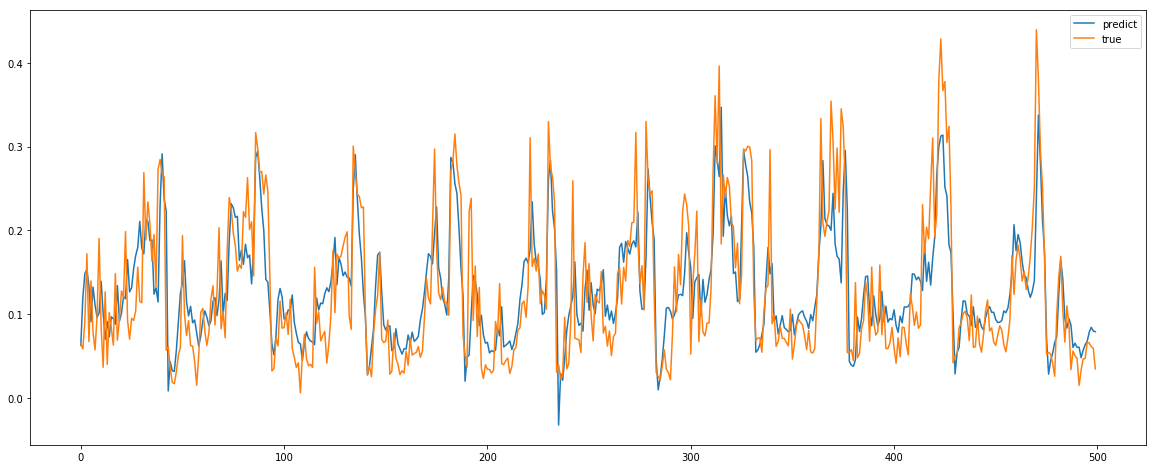

In [0]:
#Ploteamos la predicción.
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))

Mean squared error: 0.004


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

Root mean squared error: 0.066


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : 0.701


In [0]:
# create empty table with 4 fields
testPredict_dataset_like = np.zeros(shape=(len(yhat), 12) )
# put the predicted values in the right field
testPredict_dataset_like[:,0] = yhat[:,0]
# inverse transform and then select the right field
testPredict = scaler.inverse_transform(testPredict_dataset_like)[:,0]

In [0]:
# create empty table with 4 fields
testY_dataset_like = np.zeros(shape=(len(testY), 12) )
# put the predicted values in the right field
testY_dataset_like[:,0] = testY[:]
# inverse transform and then select the right field
testYnormal = scaler.inverse_transform(testY_dataset_like)[:,0]

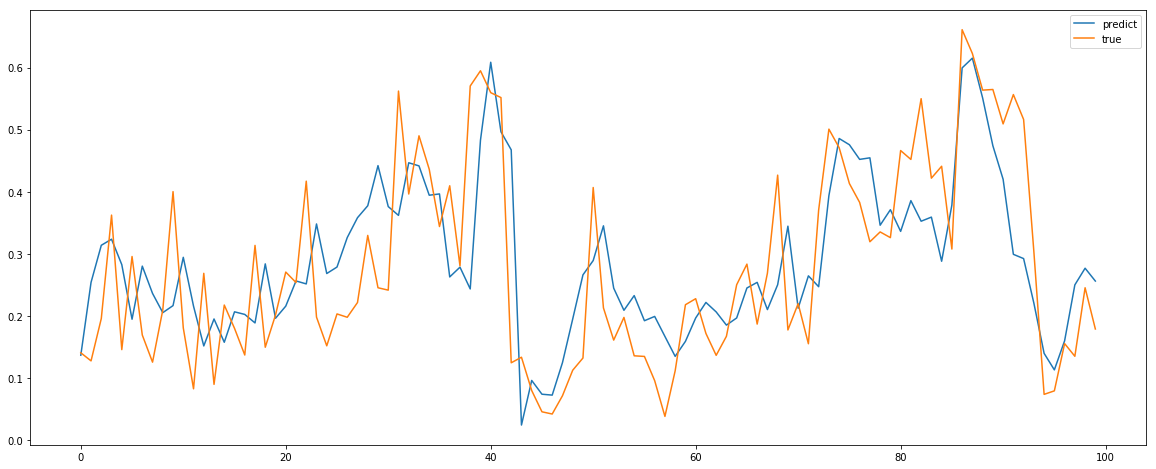

In [0]:
#Ploteamos ver la predicción.
pyplot.figure(figsize=(20,8))
pyplot.plot(testPredict[:100], label='predict')
pyplot.plot(testYnormal[:100], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testYnormal, testPredict))

Mean squared error: 0.018


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testYnormal, testPredict)))

Root mean squared error: 0.136


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testYnormal, testPredict))

Variance : 0.701


In [0]:
from sklearn.metrics import mean_absolute_error
print("Mean absolute error: %.3f" % mean_absolute_error(testYnormal, testPredict))

Mean absolute error: 0.101
